In [1]:
import pandas as pd
import re
from nlp import Dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import numpy as np

In [2]:
# read in our tweet sample
tweets = pd.read_csv('../data/tweets_sample.csv', encoding='ISO-8859-1')
tweets.dropna(inplace=True)
print(tweets.shape)
tweets.head()

(6842, 7)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month
0,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1
1,29700,74652,Liverpool,01-04-2020,Meet Alan Supermarket staff like him are worki...,Positive,1
2,29703,74655,"Oklahoma City, OK",01-04-2020,Shopping online has been the go-to option for ...,Positive,1
3,29704,74656,"Minot, ND",01-04-2020,Marketplace Foods in Minot has had the service...,Neutral,1
4,29707,74659,"Lichfield, England",01-04-2020,News Boss of supermarket says buying limits wi...,Neutral,1


In [3]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

print(tweets['OriginalTweet'].iloc[2])
print()
print(clean_tweet(tweets['OriginalTweet'].iloc[2]))




https://t.co/0al9keYAuf



url


In [4]:
tweets['text'] = tweets['OriginalTweet'].apply(clean_tweet)

tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text
0,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...
1,29700,74652,Liverpool,01-04-2020,Meet Alan Supermarket staff like him are worki...,Positive,1,Meet Alan Supermarket staff like him are worki...
2,29703,74655,"Oklahoma City, OK",01-04-2020,Shopping online has been the go-to option for ...,Positive,1,Shopping online has been the go-to option for ...
3,29704,74656,"Minot, ND",01-04-2020,Marketplace Foods in Minot has had the service...,Neutral,1,Marketplace Foods in Minot has had the service...
4,29707,74659,"Lichfield, England",01-04-2020,News Boss of supermarket says buying limits wi...,Neutral,1,News Boss of supermarket says buying limits wi...


<AxesSubplot:>

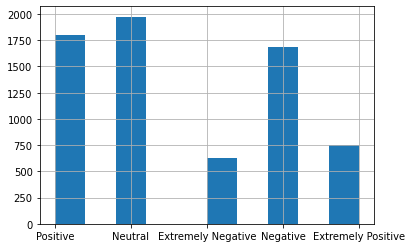

In [5]:
tweets['Sentiment'].hist()

In [6]:
tweets['label'] = tweets['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
})

<AxesSubplot:>

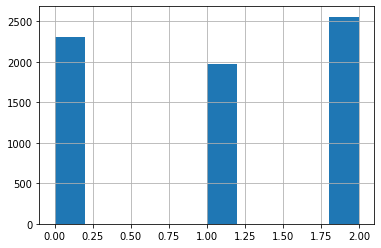

In [7]:
tweets['label'].hist()

In [8]:
tweets.to_csv('../data/cleaned_tweets.csv', index=False)

In [9]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [10]:
tweet_dataset = Dataset.from_pandas(tweets[['text', 'label']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# load our tokenizer

BERT_MODEL = 'distilbert-base-uncased'

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)

In [12]:
# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


In [13]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [14]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
len(train_set)

5473

In [16]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

In [17]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32


{'eval_loss': 1.107792854309082,
 'eval_accuracy': 0.3316289262235208,
 'eval_runtime': 11.6021,
 'eval_samples_per_second': 117.996,
 'eval_steps_per_second': 3.706}

In [18]:
trainer.train()

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5473
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 344


Epoch,Training Loss,Validation Loss,Accuracy
1,0.767000,0.533790,0.800584
2,0.396900,0.476441,0.835646


***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-172
Configuration saved in ./clf/results/checkpoint-172/config.json
Model weights saved in ./clf/results/checkpoint-172/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-344
Configuration saved in ./clf/results/checkpoint-344/config.json
Model weights saved in ./clf/results/checkpoint-344/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./clf/results/checkpoint-344 (score: 0.4764409065246582).


TrainOutput(global_step=344, training_loss=0.5819592586783475, metrics={'train_runtime': 748.5177, 'train_samples_per_second': 14.624, 'train_steps_per_second': 0.46, 'total_flos': 331350856421364.0, 'train_loss': 0.5819592586783475, 'epoch': 2.0})

In [19]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32


{'eval_loss': 0.4764409065246582,
 'eval_accuracy': 0.8356464572680788,
 'eval_runtime': 12.3028,
 'eval_samples_per_second': 111.276,
 'eval_steps_per_second': 3.495,
 'epoch': 2.0}

In [20]:
trainer.save_model()

Saving model checkpoint to ./clf/results
Configuration saved in ./clf/results/config.json
Model weights saved in ./clf/results/pytorch_model.bin


In [23]:
api_key = 'your HUGGINGFACE API KEY here'

In [30]:
# need to install  git-lfs. Eg  `brew install git-lfs`

sequence_classification_model.push_to_hub(
    "profoz/mlops-demo", 
    use_auth_token=api_key,
    use_temp_dir=True,
    
)

bert_tokenizer.push_to_hub(
    "profoz/mlops-demo", 
    use_auth_token=api_key,
    use_temp_dir=True,
    revision='1'
)


/opt/homebrew/lib/python3.9/site-packages/huggingface_hub/hf_api.py:723: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/profoz/mlops-demo into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Configuration saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmp5c2cfroq/config.json
Model weights saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmp5c2cfroq/pytorch_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

To https://huggingface.co/profoz/mlops-demo
   58ade4c..2772074  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/homebrew/lib/python3.9/site-packages/huggingface_hub/hf_api.py:723: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/profoz/mlops-demo into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

tokenizer config file saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmpip0h8jpo/tokenizer_config.json
Special tokens file saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmpip0h8jpo/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/profoz/mlops-demo
   2772074..a63755a  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/profoz/mlops-demo/commit/a63755a084251e634df91758df6e29c37bd4a11d'

In [25]:
import requests

API_URL = 'https://api-inference.huggingface.co/models/profoz/mlops-demo'
headers = {"Authorization": f'Bearer {api_key}'}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# huggingface API goes to sleep when not in use for a bit
output = query({'inputs': 'covid sucks so bad'})
output

{'error': 'Model profoz/mlops-demo is currently loading', 'estimated_time': 20}

In [28]:
# a few seconds later..
output = query({'inputs': 'covid sucks so bad'})
output

[[{'label': 'Negative', 'score': 0.7221869230270386},
  {'label': 'Neutral', 'score': 0.12886649370193481},
  {'label': 'Positive', 'score': 0.14894655346870422}]]

In [26]:
# change these for different labels
print(sequence_classification_model.config.id2label)

print(sequence_classification_model.config.label2id)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}
{'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}
